## Load libraries

In [49]:
import yt
import caesar
import numpy as np
import matplotlib.pyplot as plt
import unyt

import swiftemulator as se
from swiftemulator.design import latin
from swiftemulator.io.swift import load_parameter_files
from swiftemulator.emulators import gaussian_process, gaussian_process_mcmc, gaussian_process_bins
from swiftemulator.mean_models.polynomial import PolynomialMeanModel
from swiftemulator.sensitivity import basic, cross_check, cross_check_bins
from swiftemulator.mocking import mock_sweep
from swiftemulator.comparison.penalty import L2PenaltyCalculator
from swiftemulator.comparison.visualisation import visualise_penalties_mean, visualise_penalties_generic_statistic

import swiftpipeline as sp

from velociraptor.observations import load_observation, load_observations
from scipy.optimize import curve_fit

import os
from glob import glob
from pathlib import Path

## Load simulated data (galaxy functions, scaling relations, ...)

In [2]:
num_calis = 16
#cali_list = ["cali_%s" % str(i).zfill(4) for i in range(num_calis)]
cali_list = ["cali_%04d" % i for i in range(num_calis)]
print(cali_list)

['cali_0000', 'cali_0001', 'cali_0002', 'cali_0003', 'cali_0004', 'cali_0005', 'cali_0006', 'cali_0007', 'cali_0008', 'cali_0009', 'cali_0010', 'cali_0011', 'cali_0012', 'cali_0013', 'cali_0014', 'cali_0015']


In [3]:
snap_prefix = 'doug_s18n128'
snap_num = '0015'
#cali_num = 'cali_0000'
snap_dir = '/scratch/b/babul/aspadawe/swift_tests/cali_simba'

In [4]:
#snaps = []
#caesars = []
gsmf_logM = []
gsmf_logPhi = []

for cali in cali_list:
#    snap = os.path.join(snap_dir, cali, snap_prefix+'_'+snap_num+'.hdf5')
#    caesar_file = os.path.join(snap_dir, cali_num, snap_prefix+'_caesar_'+snap_num+'.hdf5')
    gsmf_file = os.path.join(snap_dir, cali, snap_prefix+'_gsmf_'+snap_num+'.txt')
    print(gsmf_file)
    
#    ds = yt.load(snap)
#    snaps.append(ds)
    
#    obj = caesar.load(caesar_file)
#    caesars.append(obj)

    data = np.loadtxt(gsmf_file)
    logM = data[:,0]
    logPhi = np.log10(data[:,1])
    
    # Sanitize data of -inf, +inf, NaN values
    isfinite = np.isfinite(logPhi)
    logM = logM[isfinite]
    logPhi = logPhi[isfinite]
    
    gsmf_logM.append(logM)
    gsmf_logPhi.append(logPhi)
    
#print(gsmf_logM)
#print(gsmf_Phi)

/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0000/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0001/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0002/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0003/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0004/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0005/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0006/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0007/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0008/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0009/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_0010/doug_s18n128_gsmf_0015.txt
/scratch/b/babul/aspadawe/swift_tests/cali_simba/cali_

/tmp/ipykernel_207321/35807938.py:20: RuntimeWarning: divide by zero encountered in log10
  logPhi = np.log10(data[:,1])


[-1.31608205 -1.86892401]


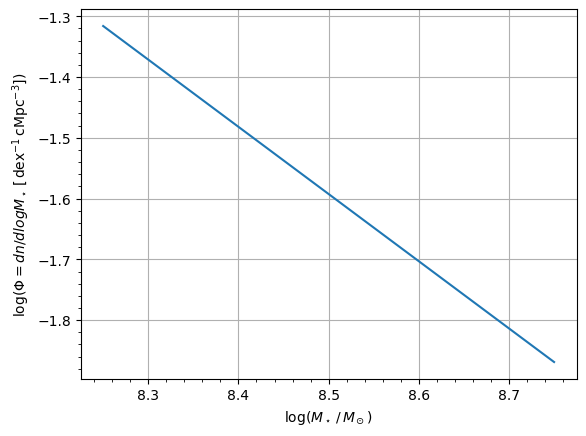

[-1.35545274 -1.7932033 ]


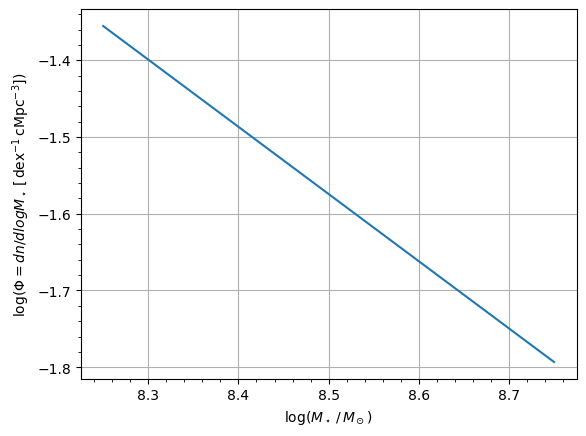

[-1.36832166 -1.80197722]


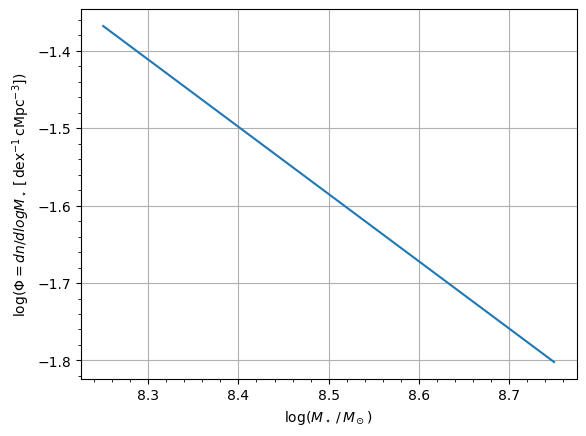

[-1.36183954 -1.75181062]


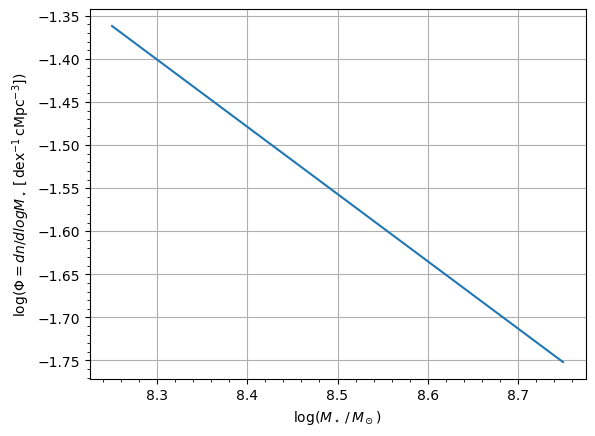

[-1.29627365 -1.91238971]


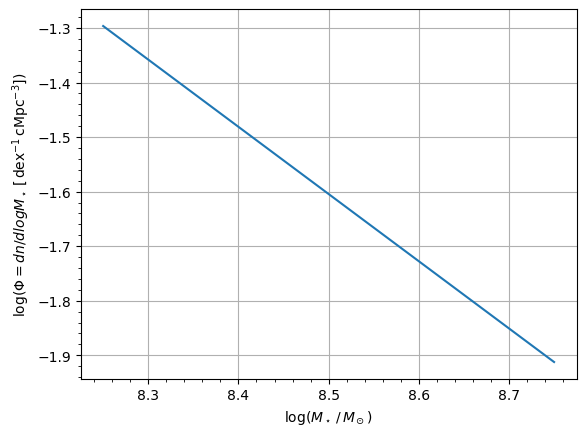

[-1.34295419 -1.7932033 ]


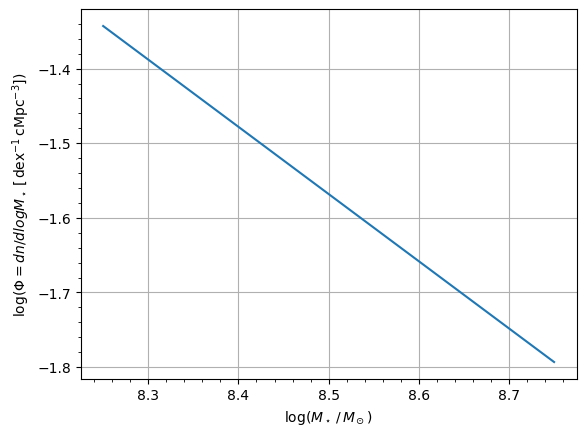

[-1.31608205 -1.63484081 -3.19114331]


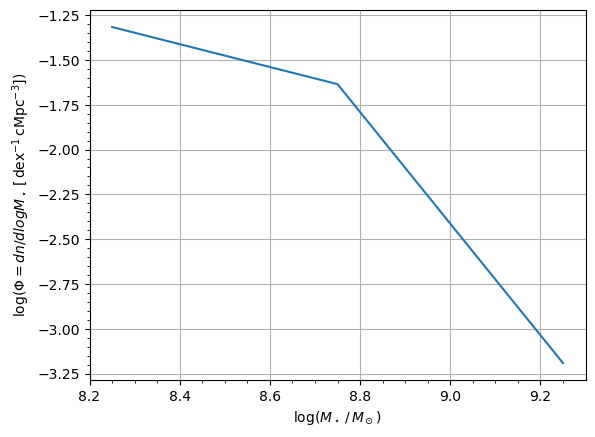

[-1.42771532 -1.83896079]


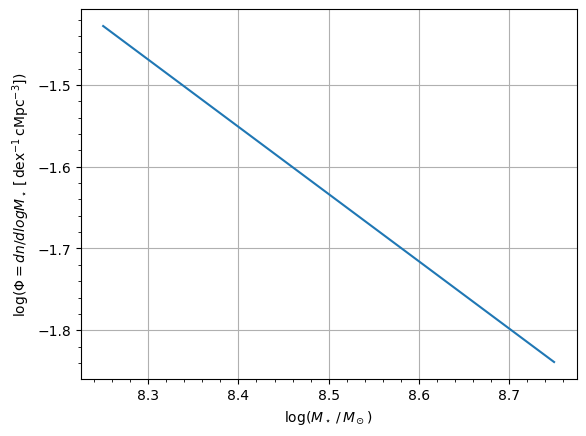

[-1.36832166 -1.78460313]


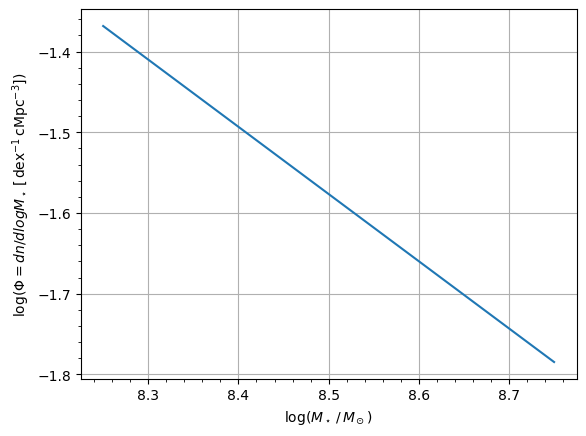

[-1.29904871 -1.72132129 -3.19114331 -3.4921733 ]


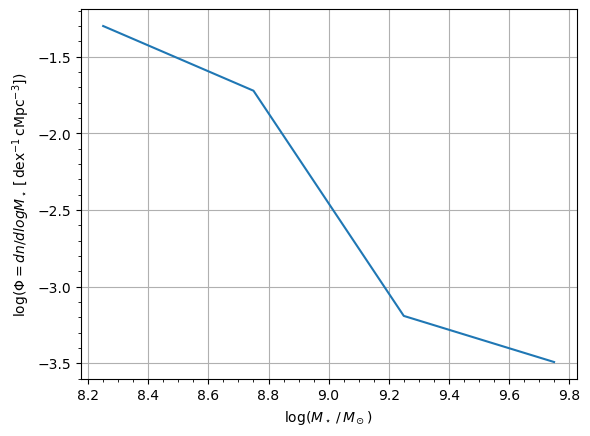

[-1.32485597 -1.76789744]


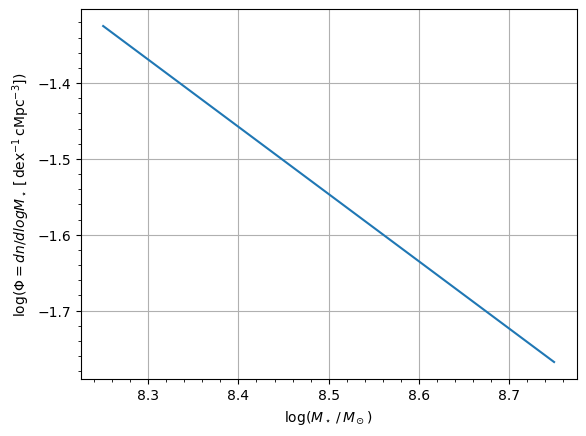

[-1.39875162 -1.84872063]


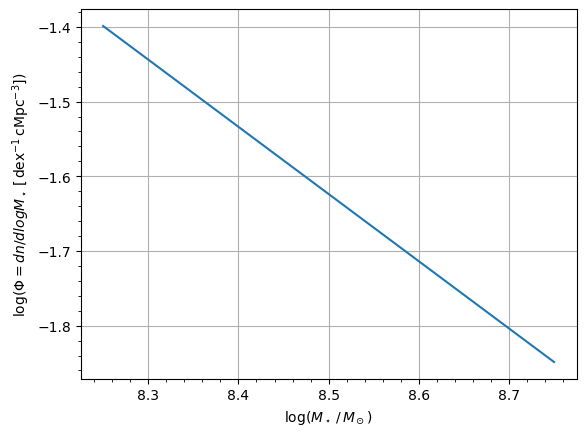

[-1.33381081 -1.81093207 -3.4921733 ]


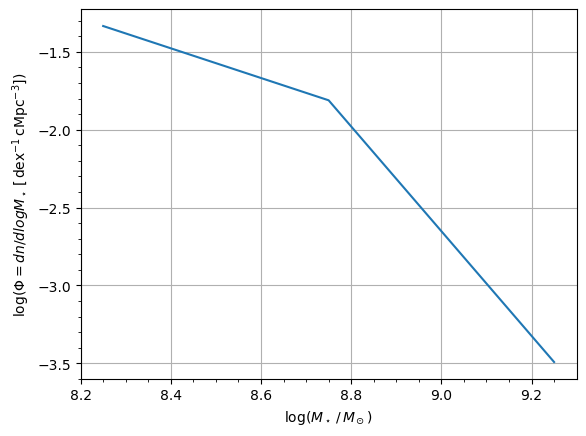

[-1.37490201 -1.75181062 -3.4921733 ]


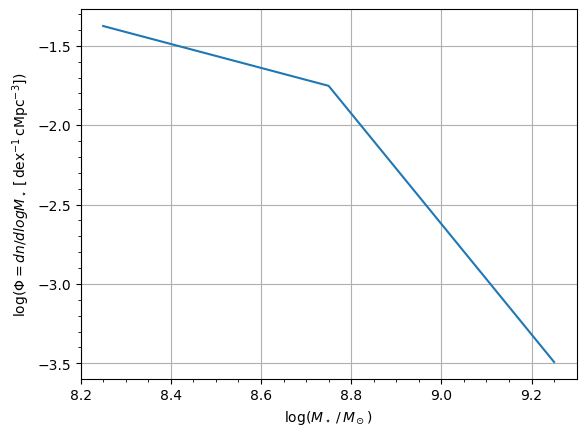

[-1.3308053  -1.76789744 -3.4921733 ]


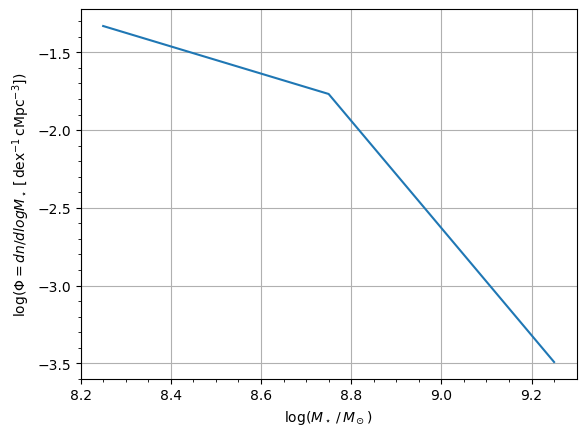

[-1.37822995 -1.74398528]


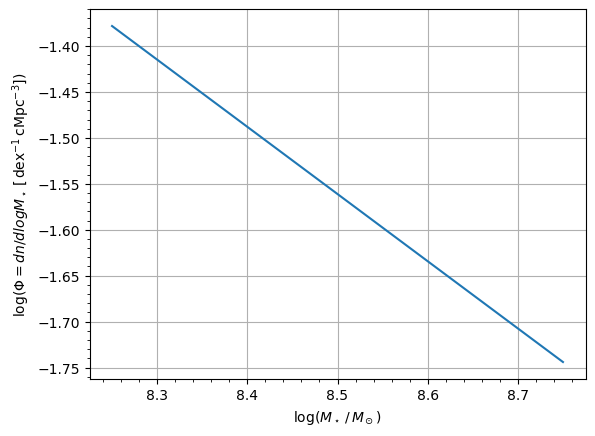

In [5]:
# Plot the GSMFs to check it worked

for check in range(num_calis):
    print(gsmf_logPhi[check])

    #fig, ax = plt.subplots()
    plt.clf()
    #plt.yscale('log')
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel(r'$\log(\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
    #plt.title(r'%s, snap %s, z=%s, nbins=%s' % (cali_num, snap_num, z, nbins))
    #plt.ylabel(r'$\log{(\Phi\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])}$')
    #plt.plot(Max,Phi,ls='steps-post')
    plt.grid()
    plt.minorticks_on()
    #plt.tick_params(axis="y",direction="in")#, left="off",labelleft="on")
    plt.plot(gsmf_logM[check],gsmf_logPhi[check],ls='-')
    #plt.plot(Max,np.log10(Phi),ls='-')
    plt.show()

## Specify the model parameters and values

In [6]:
parameter_files = [Path(x) for x in glob("/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/*.yml")]
parameter_filenames = {filename.stem: filename for filename in parameter_files}
print(parameter_files)
print()
print(parameter_filenames)

[PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/4.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/14.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/5.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/2.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/15.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/0.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/8.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/6.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/3.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/1.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/11.yml'), PosixPath('/scratch/b/babul/aspadawe/swift_tests/cali_simba/original_ymls/9.yml'), 

In [7]:
model_specification, model_parameters = load_parameter_files(
    filenames=parameter_filenames,
    parameters=[
        "SIMBAAGN:xray_f_gas_limit",
        "SIMBAAGN:f_accretion",
        "SIMBAAGN:torque_accretion_norm",
        "SIMBAAGN:wind_momentum_flux"
    ],
    log_parameters=[
    ],
    parameter_printable_names=[
        "$f_{\\rm gas,xray}$",
        "$f_{\\rm acc}$",
        "$\epsilon_{\\rm torque}$",
        "Momentum flux"
    ],
)
print(model_specification)
print()
print(model_parameters)

ModelSpecification(number_of_parameters=4, parameter_names=['SIMBAAGN:xray_f_gas_limit', 'SIMBAAGN:f_accretion', 'SIMBAAGN:torque_accretion_norm', 'SIMBAAGN:wind_momentum_flux'], parameter_limits=[[0.2484490482517083, 0.9535354367676403], [0.06382175956324224, 0.3895955351217842], [0.07321359834183083, 0.4719937222653178], [21.487637984541763, 97.03335554421214]], parameter_printable_names=['$f_{\\rm gas,xray}$', '$f_{\\rm acc}$', '$\\epsilon_{\\rm torque}$', 'Momentum flux'])

ModelParameters(model_parameters={'4': {'SIMBAAGN:xray_f_gas_limit': 0.2804346099979346, 'SIMBAAGN:f_accretion': 0.3123626717299527, 'SIMBAAGN:torque_accretion_norm': 0.3557999320624141, 'SIMBAAGN:wind_momentum_flux': 55.39631118088475}, '14': {'SIMBAAGN:xray_f_gas_limit': 0.2484490482517083, 'SIMBAAGN:f_accretion': 0.19771832096391256, 'SIMBAAGN:torque_accretion_norm': 0.12727635950863653, 'SIMBAAGN:wind_momentum_flux': 91.59071772026137}, '5': {'SIMBAAGN:xray_f_gas_limit': 0.34893982287895886, 'SIMBAAGN:f_accr

In [8]:
modelvalues = {}
for unique_identifier in model_parameters.model_parameters:
    independent = gsmf_logM[int(unique_identifier)]
    dependent = gsmf_logPhi[int(unique_identifier)]
    dependent_error = 0.0 * dependent
    modelvalues[unique_identifier] = {"independent": independent,
                                    "dependent": dependent,
                                    "dependent_error": dependent_error}
#    modelvalues[unique_identifier] = {"independent": independent,
#                                      "dependent": dependent}

model_values = se.ModelValues(model_values=modelvalues)
print(modelvalues)
print()
print(model_values)

{'4': {'independent': array([8.25, 8.75]), 'dependent': array([-1.29627365, -1.91238971]), 'dependent_error': array([-0., -0.])}, '14': {'independent': array([8.25, 8.75, 9.25]), 'dependent': array([-1.3308053 , -1.76789744, -3.4921733 ]), 'dependent_error': array([-0., -0., -0.])}, '5': {'independent': array([8.25, 8.75]), 'dependent': array([-1.34295419, -1.7932033 ]), 'dependent_error': array([-0., -0.])}, '2': {'independent': array([8.25, 8.75]), 'dependent': array([-1.36832166, -1.80197722]), 'dependent_error': array([-0., -0.])}, '15': {'independent': array([8.25, 8.75]), 'dependent': array([-1.37822995, -1.74398528]), 'dependent_error': array([-0., -0.])}, '0': {'independent': array([8.25, 8.75]), 'dependent': array([-1.31608205, -1.86892401]), 'dependent_error': array([-0., -0.])}, '8': {'independent': array([8.25, 8.75]), 'dependent': array([-1.36832166, -1.78460313]), 'dependent_error': array([-0., -0.])}, '6': {'independent': array([8.25, 8.75, 9.25]), 'dependent': array([-1

## Train emulator

In [9]:
gsmf_emulator = gaussian_process.GaussianProcessEmulator()  # Default
#gsmf_emulator = gaussian_process_bins.GaussianProcessEmulatorBins()  # Binned
#polynomial_model = PolynomialMeanModel(degree=2)  # Polynomial mean model
#gsmf_emulator = gaussian_process.GaussianProcessEmulator(mean_model=polynomial_model)  # Mean model

gsmf_emulator.fit_model(model_specification=model_specification,
                            model_parameters=model_parameters,
                            model_values=model_values)

In [10]:
gsmf_emulator

GaussianProcessEmulator(kernel=ConstantKernel(log_constant=-1.6094379124341003, ndim=5, axes=array([0, 1, 2, 3, 4])) * ExpSquaredKernel(metric=Metric(array([1., 1., 1., 1., 1.]), ndim=5, axes=array([0, 1, 2, 3, 4]), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None)]), block=None), mean_model=None)

In [11]:
gsmf_emulator.parameter_order

['SIMBAAGN:xray_f_gas_limit',
 'SIMBAAGN:f_accretion',
 'SIMBAAGN:torque_accretion_norm',
 'SIMBAAGN:wind_momentum_flux']

## Make predictions and compare

In [12]:
model_parameters['4']

{'SIMBAAGN:xray_f_gas_limit': 0.2804346099979346,
 'SIMBAAGN:f_accretion': 0.3123626717299527,
 'SIMBAAGN:torque_accretion_norm': 0.3557999320624141,
 'SIMBAAGN:wind_momentum_flux': 55.39631118088475}

In [13]:
model_values.model_values['4']['independent']

array([8.25, 8.75])

In [14]:
model_values['4']['dependent']

array([-1.29627365, -1.91238971])

[8.25 8.75]
[-1.316082   -1.86892402]
[1.25011113e-12 1.25055521e-12]


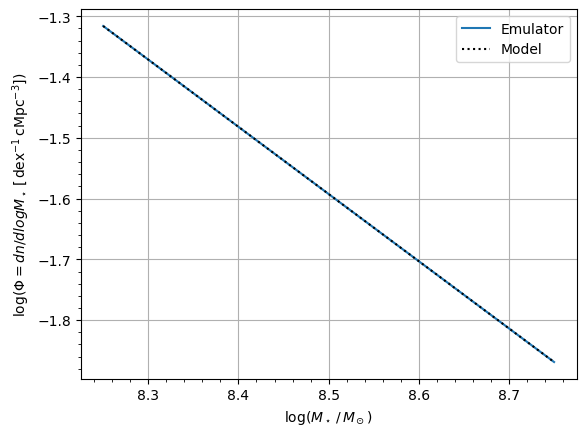

[8.25 8.75]
[-1.35545278 -1.79320335]
[1.25011113e-12 1.25055521e-12]


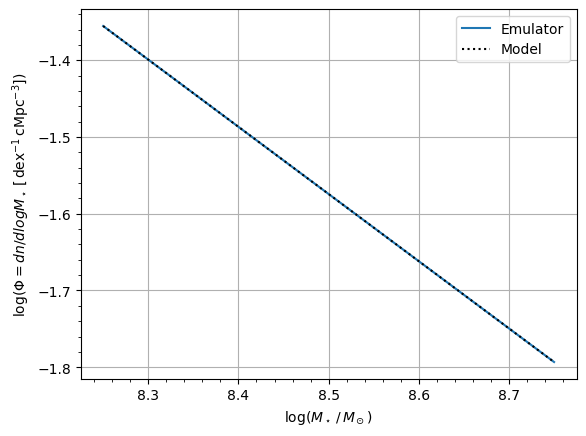

[8.25 8.75]
[-1.36832166 -1.80197728]
[1.24966704e-12 1.24966704e-12]


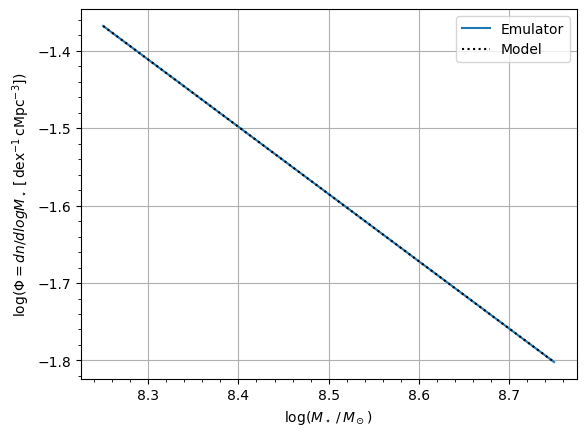

[8.25 8.75]
[-1.36183953 -1.75181067]
[1.24966704e-12 1.25011113e-12]


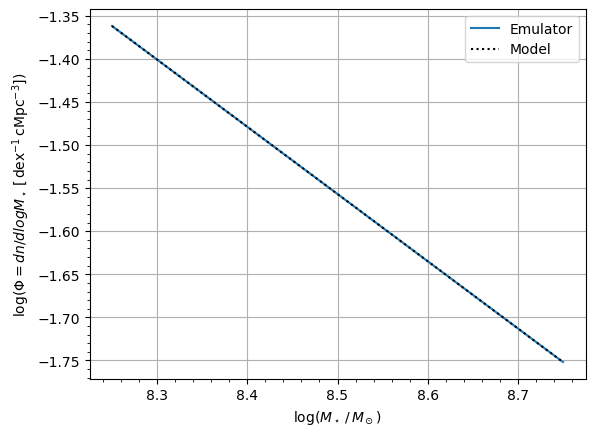

[8.25 8.75]
[-1.29627371 -1.91238976]
[1.25011113e-12 1.25055521e-12]


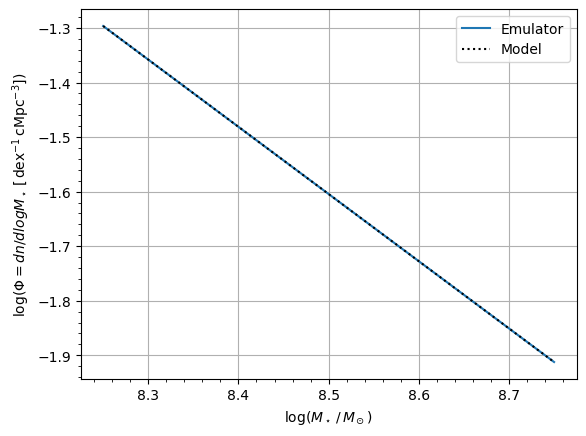

[8.25 8.75]
[-1.34295416 -1.79320335]
[1.25011113e-12 1.25099930e-12]


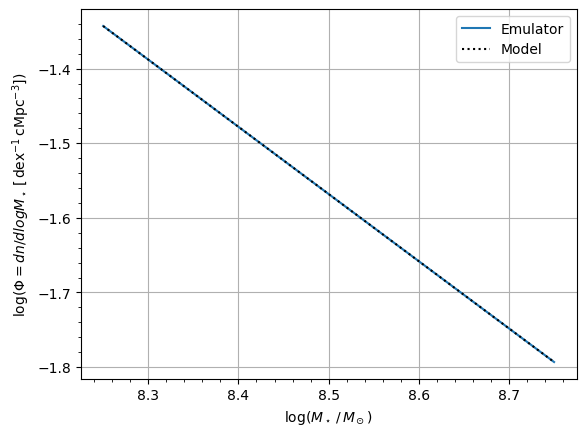

[8.25 8.75 9.25]
[-1.316082   -1.63484085 -3.19114327]
[1.25055521e-12 1.25011113e-12 1.25099930e-12]


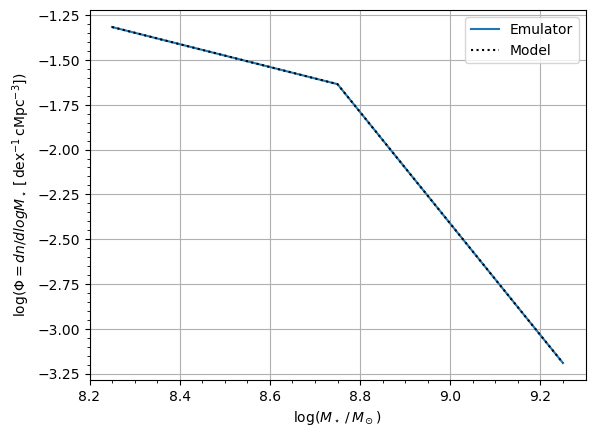

[8.25 8.75]
[-1.4277153  -1.83896077]
[1.24966704e-12 1.25055521e-12]


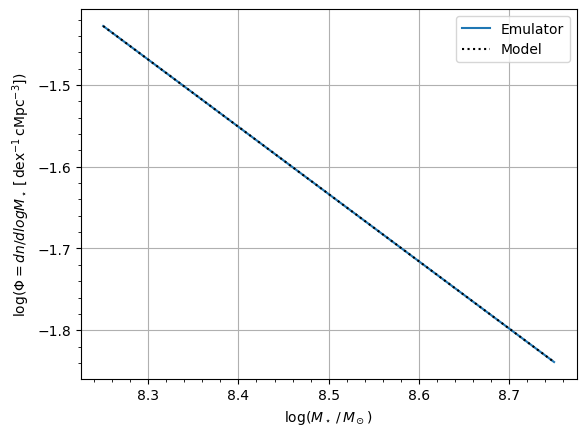

[8.25 8.75]
[-1.36832166 -1.78460312]
[1.24966704e-12 1.25055521e-12]


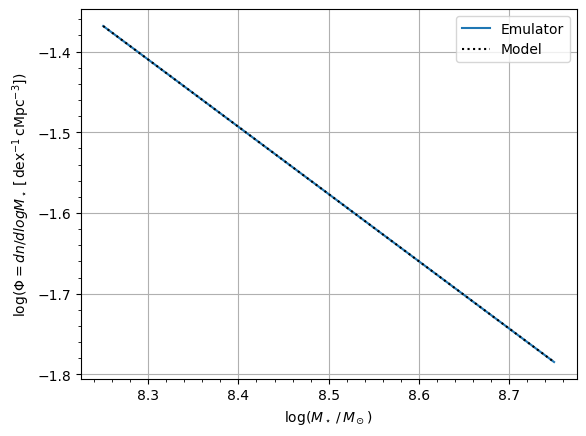

[8.25 8.75 9.25 9.75]
[-1.29904866 -1.72132134 -3.19114327 -3.49217319]
[1.25055521e-12 1.25055521e-12 1.25055521e-12 1.25099930e-12]


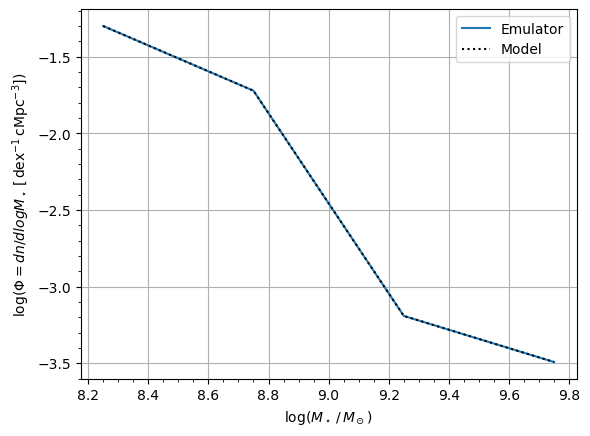

[8.25 8.75]
[-1.32485592 -1.76789749]
[1.25011113e-12 1.25055521e-12]


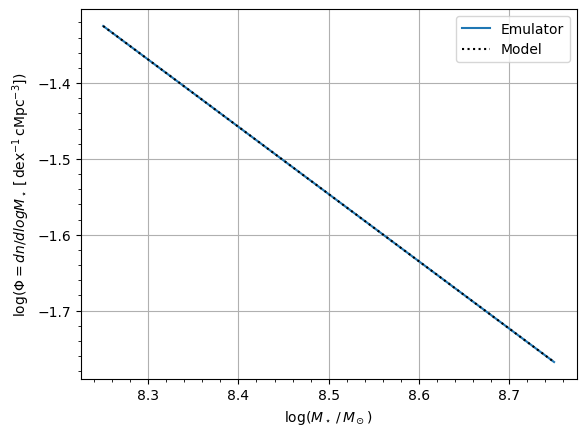

[8.25 8.75]
[-1.39875162 -1.84872067]
[1.25011113e-12 1.25099930e-12]


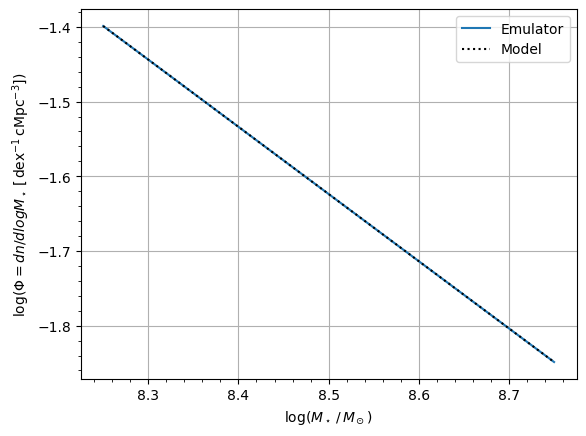

[8.25 8.75 9.25]
[-1.33381081 -1.81093204 -3.49217319]
[1.25055521e-12 1.25011113e-12 1.25011113e-12]


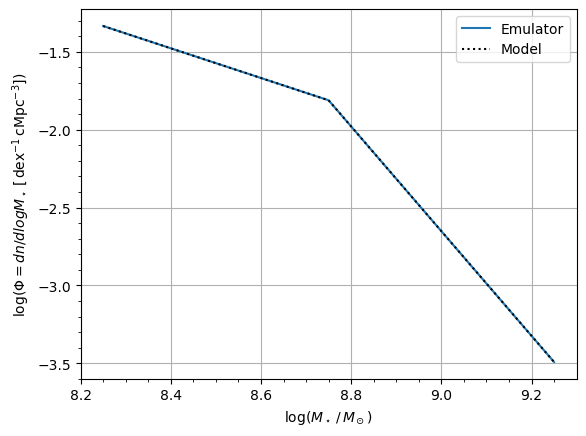

[8.25 8.75 9.25]
[-1.37490201 -1.75181067 -3.49217319]
[1.25099930e-12 1.24877886e-12 1.24966704e-12]


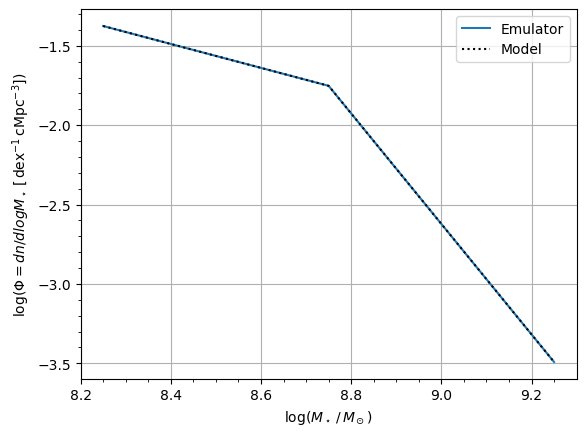

[8.25 8.75 9.25]
[-1.3308053  -1.76789749 -3.49217319]
[1.24966704e-12 1.25099930e-12 1.25055521e-12]


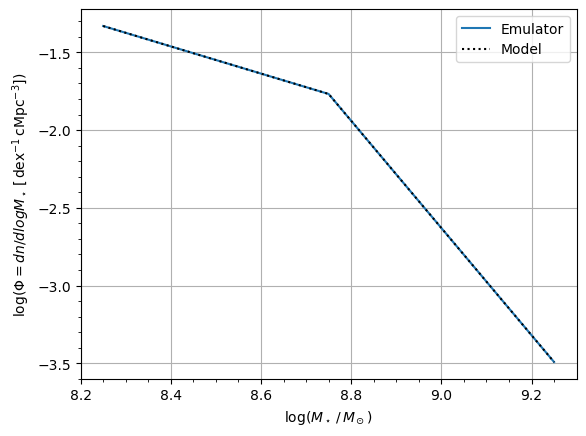

[8.25 8.75]
[-1.37822998 -1.7439853 ]
[1.25011113e-12 1.25011113e-12]


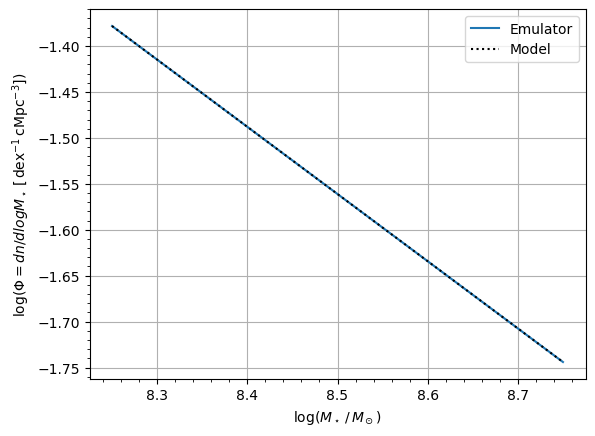

In [15]:
# Make predictions with trained emulator to compare to input

for ii in range(num_calis):
#    num = '0'
    num = str(ii)
    pred_params = model_parameters[num]
    pred_x = gsmf_emulator.model_values[num]['independent']
    sim_y = gsmf_emulator.model_values[num]['dependent']

    pred_y, pred_var = gsmf_emulator.predict_values(pred_x, pred_params)
    print(pred_x)
    print(pred_y)
    print(pred_var)

    plt.clf()
    #plt.yscale('log')
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel(r'$\log (\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
    #plt.title(r'%s, snap %s, z=%s, nbins=%s' % (cali_num, snap_num, z, nbins))
    plt.grid()
    plt.minorticks_on()
    plt.plot(pred_x, pred_y,ls='-', label='Emulator')
    plt.plot(pred_x, sim_y, color="black", ls=":", label="Model")
    plt.legend()
    plt.show()

In [16]:
# Can extrapolate!
pred_params = model_parameters['0']
gsmf_emulator.predict_values([12], pred_params)

(array([-2.37978906e-05]), array([2.01659053]))

## Parameter sensitivity analysis

In [17]:
gsmf_sensitivities = basic.binwise_sensitivity(specification=model_specification,
                                             parameters=model_parameters,
                                             values=model_values)
gsmf_sensitivities

/home/b/babul/aspadawe/miniconda3/envs/yt_swift_caesar/lib/python3.9/site-packages/SALib/analyze/rbd_fast.py:129: RuntimeWarning: invalid value encountered in double_scalars
  return D1 / V


ZeroDivisionError: division by zero

In [ ]:
basic.plot_binwise_sensitivity(specification=model_specification,
                               sensitivities=gsmf_sensitivities,
                              xlabel=r'$\log(M_\star\,/\,M_\odot)$',
                              cbarlabel='Sensitivity')

## Perform cross check (validation)

In [18]:
gsmf_ccheck = cross_check.CrossCheck()
gsmf_ccheck.build_emulators(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

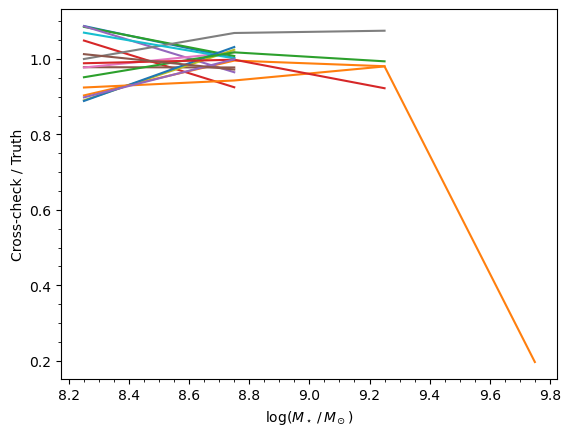

In [19]:
data_by_cc = gsmf_ccheck.build_mocked_model_values_original_independent()
#print(data_by_cc)

for unique_identifier in model_values.model_values:
#    print(unique_identifier)
    cc_over_og = data_by_cc[unique_identifier]["dependent"] / \
                model_values[unique_identifier]["dependent"]
#    cc_minus_og_over_og = (data_by_cc[unique_identifier]["dependent"] / \
#                           model_values[unique_identifier]["dependent"])/ model_values[unique_identifier]["dependent"]
    plt.plot(data_by_cc[unique_identifier]["independent"],cc_over_og)
    plt.grid()
    plt.minorticks_on()
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel("Cross-check / Truth")

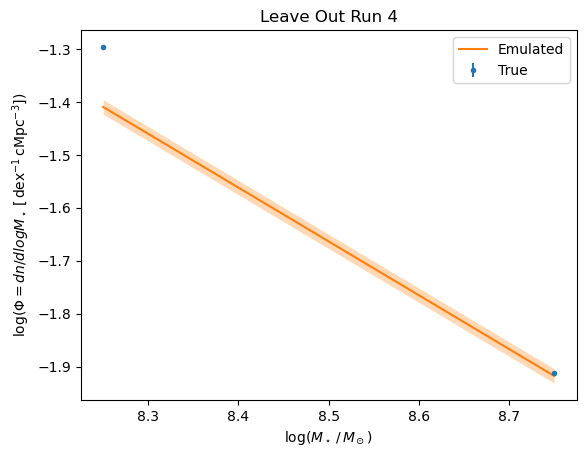

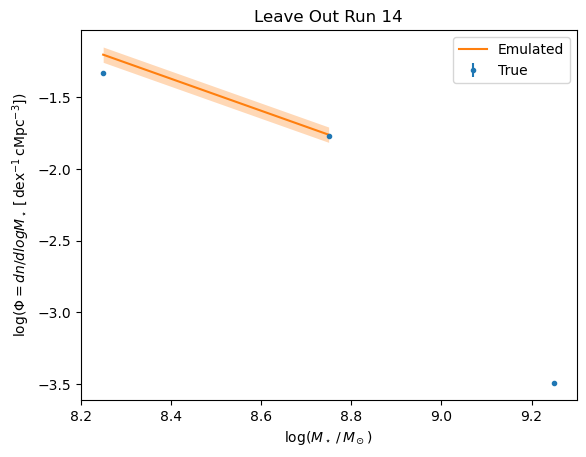

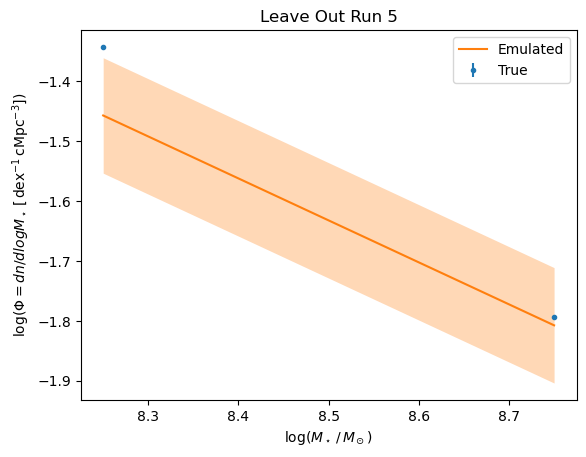

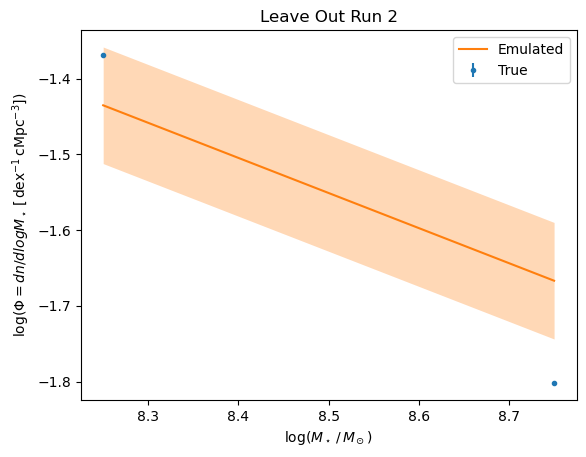

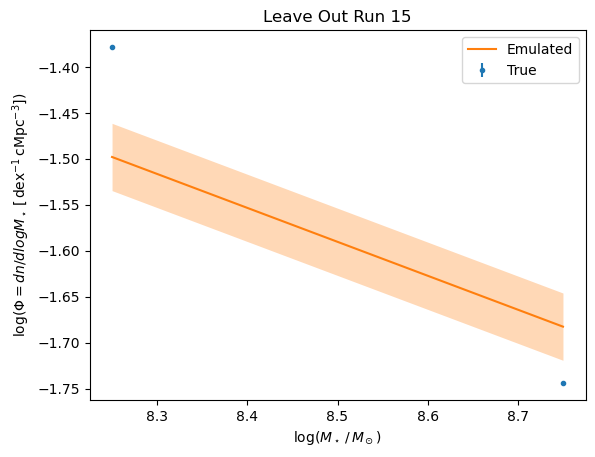

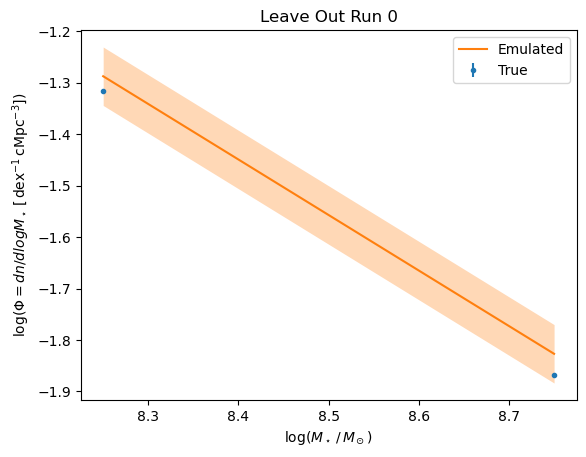

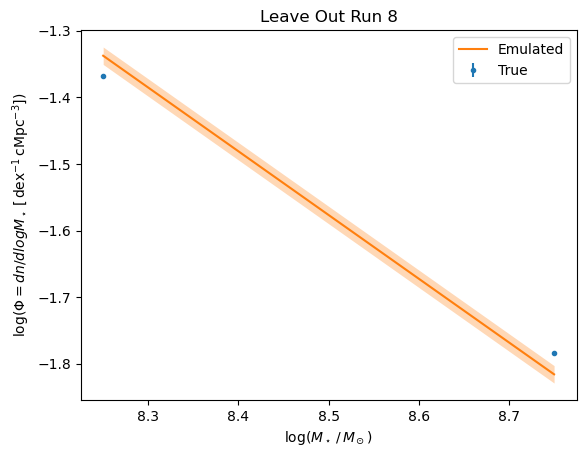

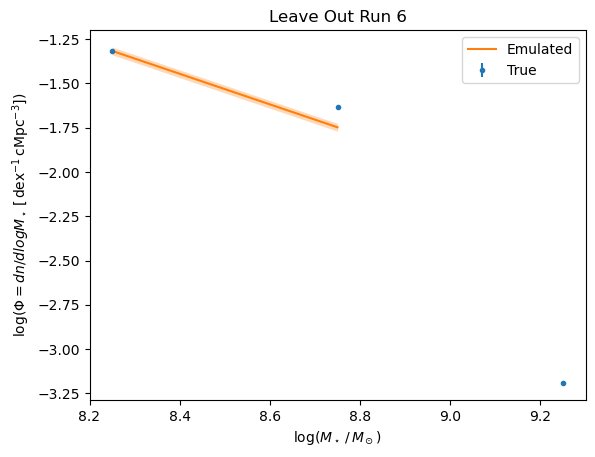

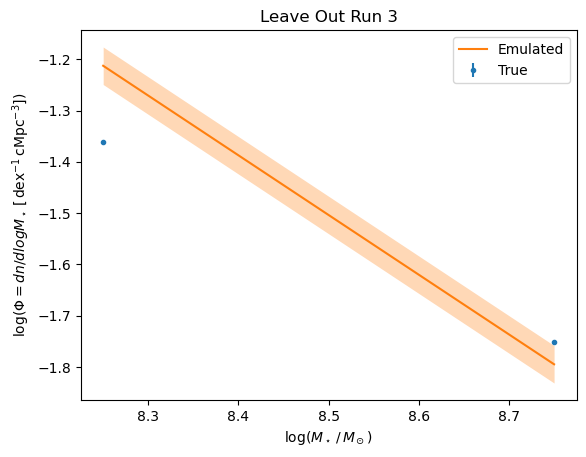

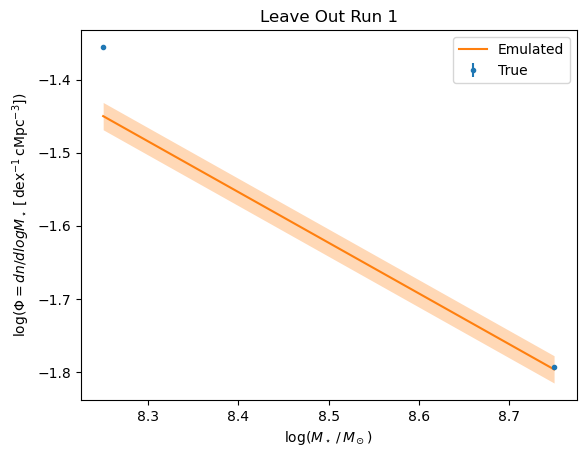

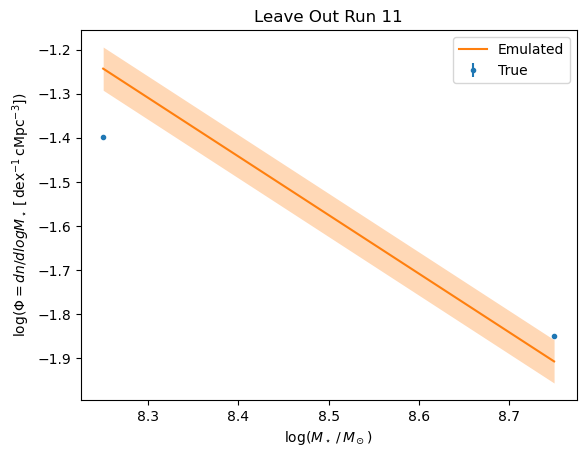

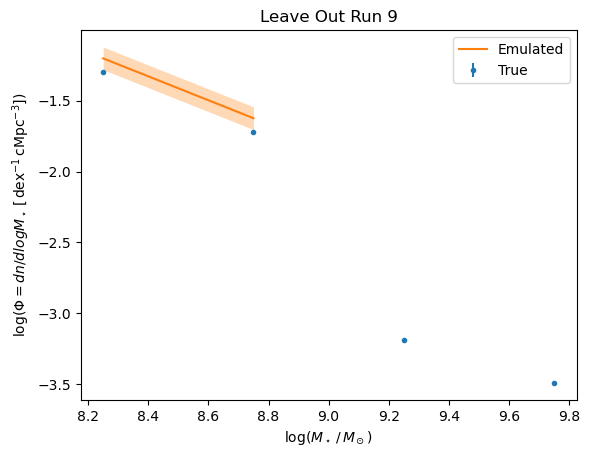

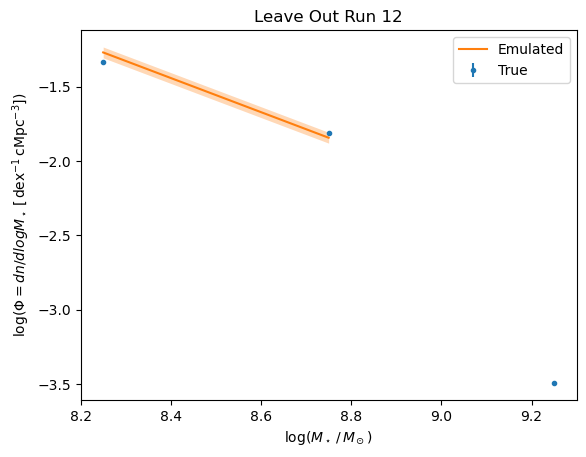

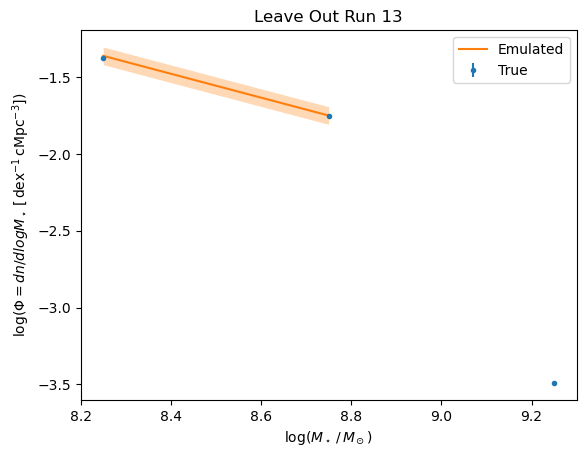

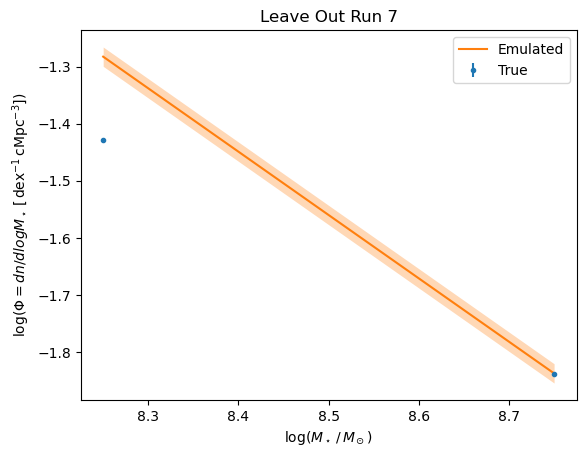

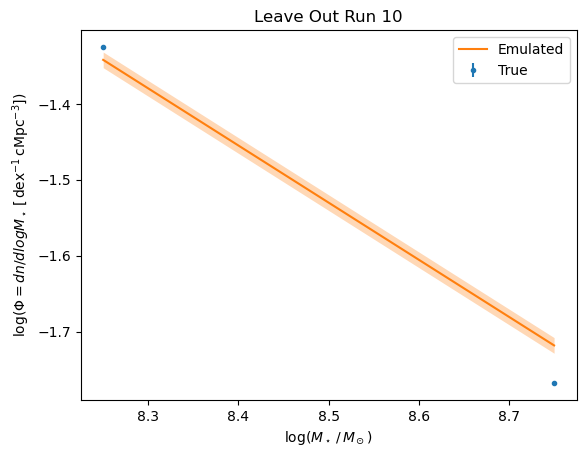

In [20]:
gsmf_ccheck.plot_results(emulate_at=data_by_cc[unique_identifier]["independent"],
                        xlabel=r'$\log(M_\star\,/\,M_\odot)$',
                        ylabel=r'$\log (\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')

In [21]:
total_mean_squared = gsmf_ccheck.get_mean_squared()[0]
print("Total mean squared of entire set of left-out simulations: %s" % total_mean_squared)

Total mean squared of entire set of left-out simulations: 0.21630998746094904


## Perform binned cross check (doesn't work)

In [ ]:
gsmf_ccheck_bins = cross_check_bins.CrossCheckBins()
gsmf_ccheck_bins.build_emulators(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

In [ ]:
gsmf_ccheck_bins.plot_results(xlabel=r'$\log(M_\star\,/\,M_\odot)$',
                              ylabel=r'$\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}]$')

In [ ]:
total_mean_squared = gsmf_ccheck_bins.get_mean_squared()[0]
print("Total mean squared of entire set of left-out simulations: %s" % total_mean_squared)

## Model Parameter Features

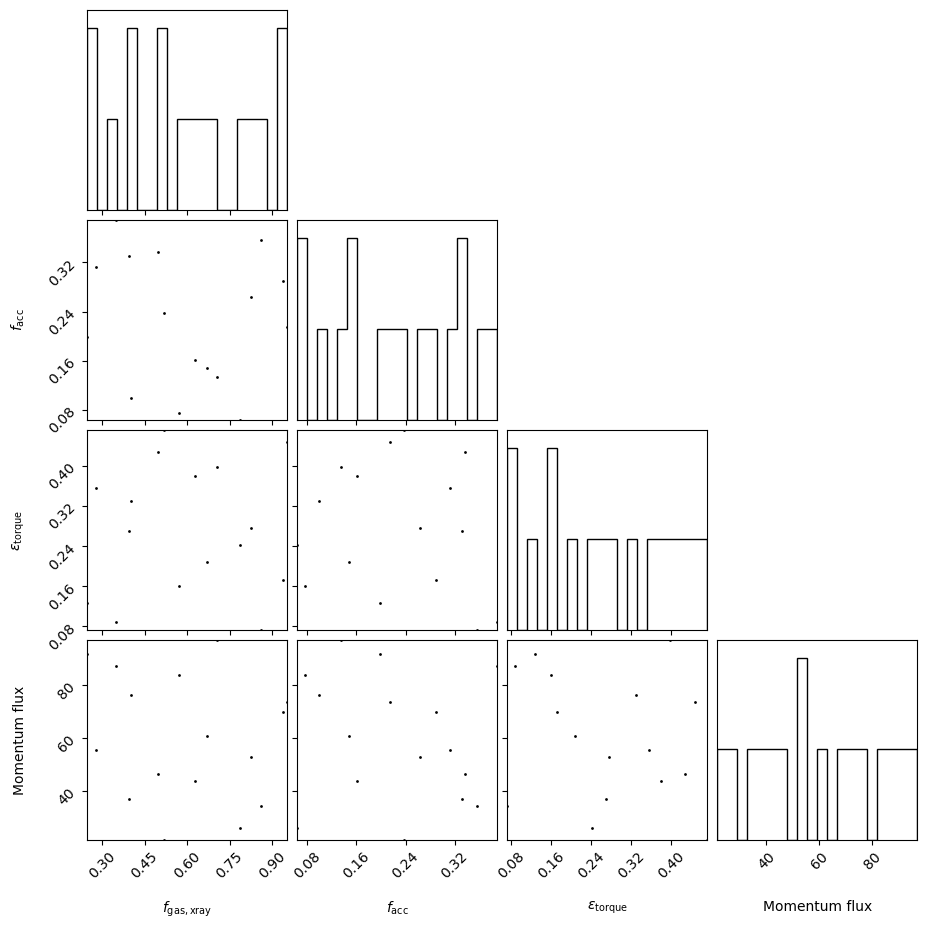

In [22]:
model_parameters.plot_model(model_specification)

In [23]:
# Models closest to best model
# But don't know best model yet b/c I haven't compared to observations yet

best_model = gsmf_emulator.model_parameters['0']

model_parameters.find_closest_model(best_model,number_of_close_models=5)

(['0', '12', '3', '6', '10'],
 [{'SIMBAAGN:xray_f_gas_limit': 0.9535354367676403,
   'SIMBAAGN:f_accretion': 0.21475691826279325,
   'SIMBAAGN:torque_accretion_norm': 0.4475036358483602,
   'SIMBAAGN:wind_momentum_flux': 73.62769640233914},
  {'SIMBAAGN:xray_f_gas_limit': 0.40187076318649934,
   'SIMBAAGN:f_accretion': 0.09897074647673551,
   'SIMBAAGN:torque_accretion_norm': 0.32992087498483613,
   'SIMBAAGN:wind_momentum_flux': 75.96049144263723},
  {'SIMBAAGN:xray_f_gas_limit': 0.9396273438695912,
   'SIMBAAGN:f_accretion': 0.28909115515459843,
   'SIMBAAGN:torque_accretion_norm': 0.1719681283477677,
   'SIMBAAGN:wind_momentum_flux': 69.56978679165695},
  {'SIMBAAGN:xray_f_gas_limit': 0.5701273027190352,
   'SIMBAAGN:f_accretion': 0.07541927270328372,
   'SIMBAAGN:torque_accretion_norm': 0.15996305465419988,
   'SIMBAAGN:wind_momentum_flux': 83.82898331458352},
  {'SIMBAAGN:xray_f_gas_limit': 0.6706117490018764,
   'SIMBAAGN:f_accretion': 0.14724561528138613,
   'SIMBAAGN:torque_acc

## Sweeps of parameter space

{'SIMBAAGN:xray_f_gas_limit': 0.9535354367676403, 'SIMBAAGN:f_accretion': 0.21475691826279325, 'SIMBAAGN:torque_accretion_norm': 0.4475036358483602, 'SIMBAAGN:wind_momentum_flux': 73.62769640233914}


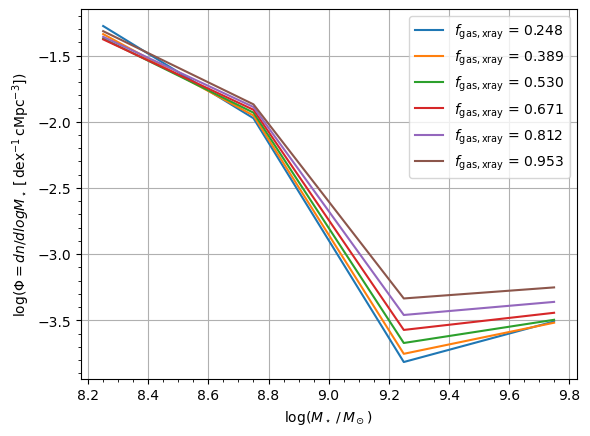

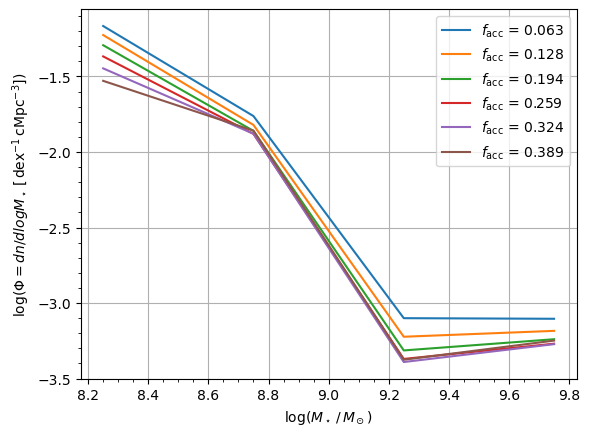

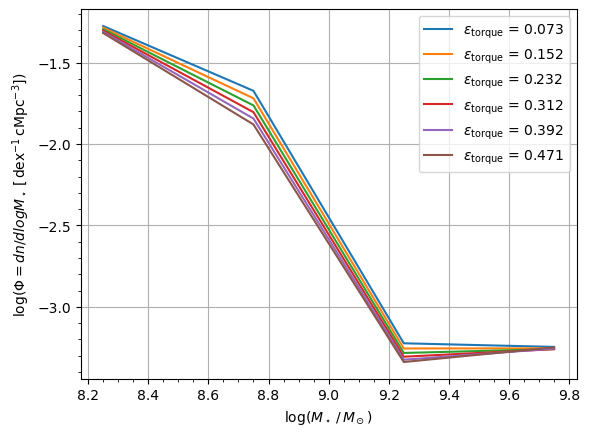

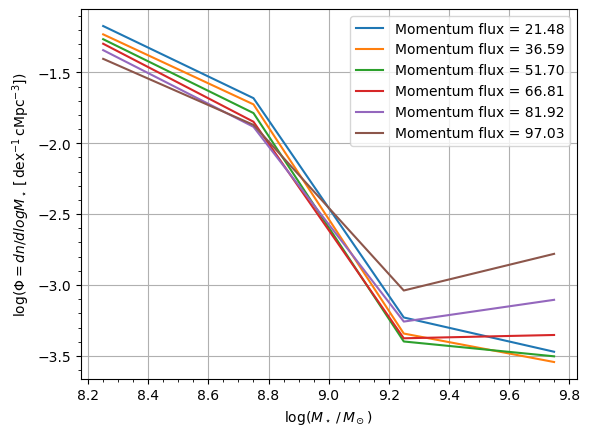

In [24]:
# Arbitrarily choose initial parameters to sweep from
# Doesn't matter too much though, because it ends up covering
# roughly the entire range of parameters used
# Although it seems the emulator results are somewhat sensitive to the exact parameters used

center = gsmf_emulator.model_parameters['0']
print(center)

for ii in range(len(gsmf_emulator.parameter_order)):
    param_name = gsmf_emulator.parameter_order[ii]
    param_printable_name = gsmf_emulator.model_specification.parameter_printable_names[ii]
    
    Mock_values, Mock_parameters = mock_sweep(gsmf_emulator
                                      ,model_specification
                                      ,6,param_name,center)
#    print(Mock_parameters)
    plt.clf()
    
    for mock_name in Mock_values.keys():
        plt.plot(Mock_values[mock_name]["independent"],
                Mock_values[mock_name]["dependent"],
                label = "%s = " % param_printable_name +str(Mock_parameters[mock_name][param_name])[:5])
    
#    plt.yscale('log')
    plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
    plt.ylabel(r'$\log (\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()

## Checking hyperparameters (doesn't work)

In [ ]:
gsmf_emulator_mcmc = gaussian_process_mcmc.GaussianProcessEmulatorMCMC(burn_in_steps=1
                                                                          ,mcmc_steps=1000)
gsmf_emulator_mcmc.fit_model(model_specification=model_specification,
                        model_parameters=model_parameters,
                        model_values=model_values)

gmsf_emulator_mcmc.plot_hyperparameter_distribution()

# Compare with observational data

## Load observational data

In [25]:
observation = load_observations(
    "/home/b/babul/aspadawe/data/gsmf/Baldry12_gsmf_schechter.hdf5"
)[0]
print(observation.cosmology)

FlatLambdaCDM(name="Flat $\Lambda$CDM", H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0)


## Penalty function

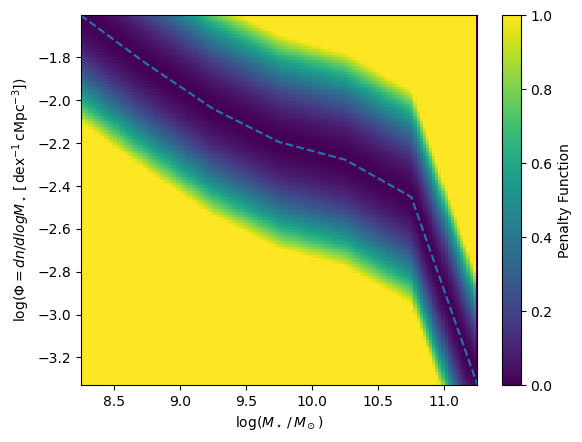

In [47]:
L2_penalty = L2PenaltyCalculator(offset = 0.5, lower=min(np.log10(observation.x)),upper=max(np.log10(observation.x)))
L2_penalty.register_observation(observation,
                                log_independent=True,
                                log_dependent=True,
                                independent_units=unyt.Msun,
                                dependent_units=unyt.Mpc**-3)

L2_penalty.plot_penalty(min(np.log10(observation.x)),max(np.log10(observation.x)),
                        min(np.log10(observation.y)),max(np.log10(observation.y)),
                        "penalty_example",
                        x_label=r'$\log(M_\star\,/\,M_\odot)$',
                        y_label=r'$\log (\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$',
                       resolution=128)

In [76]:
print(L2_penalty.observation_interpolation())

None


In [39]:
all_penalties = L2_penalty.penalties(gsmf_emulator.model_values, np.mean)
print(all_penalties)
print()

all_penalties_array = []
node_number = []
for key in all_penalties.keys():
    all_penalties_array.append(all_penalties[key])
    node_number.append(int(key))

best_node = node_number[np.argmin(all_penalties_array)]

print("Best fit node = ", best_node)

pred_params = gsmf_emulator.model_parameters[str(best_node)].copy()
print(pred_params)

{'4': 0.20323261393217057, '14': 0.43897009059608866, '5': 0.14019822980829855, '2': 0.11369657790122573, '15': 0.11827550690950456, '0': 0.1694209893099541, '8': 0.11640629888783698, '6': 0.4964672156486061, '3': 0.13102690885050447, '1': 0.12741904799858866, '11': 0.08546627661039129, '9': 0.6058062098596187, '12': 0.43186672789295777, '13': 0.41244841819989514, '7': 0.06281914225461865, '10': 0.16504666810535798}

Best fit node =  7
{'SIMBAAGN:xray_f_gas_limit': 0.49710081592469346, 'SIMBAAGN:f_accretion': 0.3372717158177846, 'SIMBAAGN:torque_accretion_norm': 0.4277111868636051, 'SIMBAAGN:wind_momentum_flux': 46.38910175409183}


In [43]:
pred_params = gsmf_emulator.model_parameters[str(best_node)].copy()
#x_to_predict = np.log10(L2_penalty.observation.x.value)
x_to_predict = gsmf_emulator.model_values[str(best_node)]['independent']
pred_y, pred_var = gsmf_emulator.predict_values(x_to_predict, pred_params)

print("Mean Penalty of node %s = %s" % (best_node, np.mean(L2_penalty.penalty(x_to_predict, pred_y))))

#Let's change one of the parameters and see if it improves the fit
pred_params["SIMBAAGN:xray_f_gas_limit"] += 0.1
#x_to_predict = np.log10(L2_penalty.observation.x.value)
pred_y, pred_var = gsmf_emulator.predict_values(x_to_predict, pred_params)

print("Mean after change = %s" % np.mean(L2_penalty.penalty(x_to_predict, pred_y)))

Mean Penalty of node 7 = 0.06281915169845582
Mean after change = 0.04999743788597204


[-1.4277153  -1.83896077 -3.7403756  -3.738868   -1.55073903 -0.25173536
 -0.01457343]
[1.24966704e-12 1.25055521e-12 2.54991430e-02 2.79850974e-01
 1.34341330e+00 1.98879095e+00 2.01648054e+00]


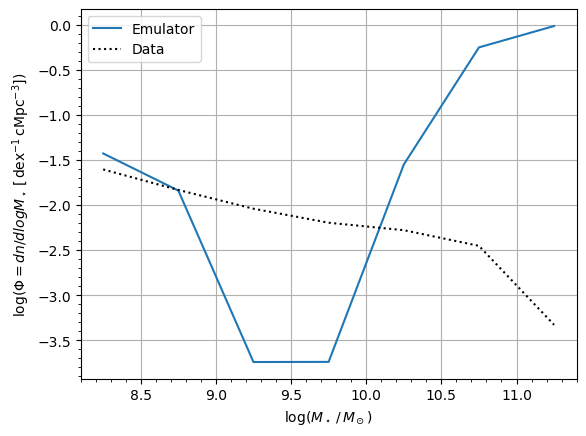

In [40]:
# Plot best fit node and data

pred_x = np.log10(L2_penalty.observation.x.value)
#pred_x = gsmf_emulator.model_values[str(best_node)]['independent']
pred_y, pred_var = gsmf_emulator.predict_values(pred_x, pred_params)
print(pred_y)
print(pred_var)

#fig, ax = plt.subplots()
plt.clf()
#plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\log(\Phi=dn/dlogM_\star\,[\,\mathrm{dex}^{-1}\,\mathrm{cMpc}^{-3}])$')
#plt.title(r'%s, snap %s, z=%s, nbins=%s' % (cali_num, snap_num, z, nbins))
plt.grid()
plt.minorticks_on()
plt.plot(pred_x, pred_y, ls='-', label='Emulator')
plt.plot(np.log10(observation.x), np.log10(observation.y), color="black", ls=":", label="Data")
#plt.plot(observation.x, observation.y, color="black", ls=":", label="Data")
plt.legend()
plt.show()

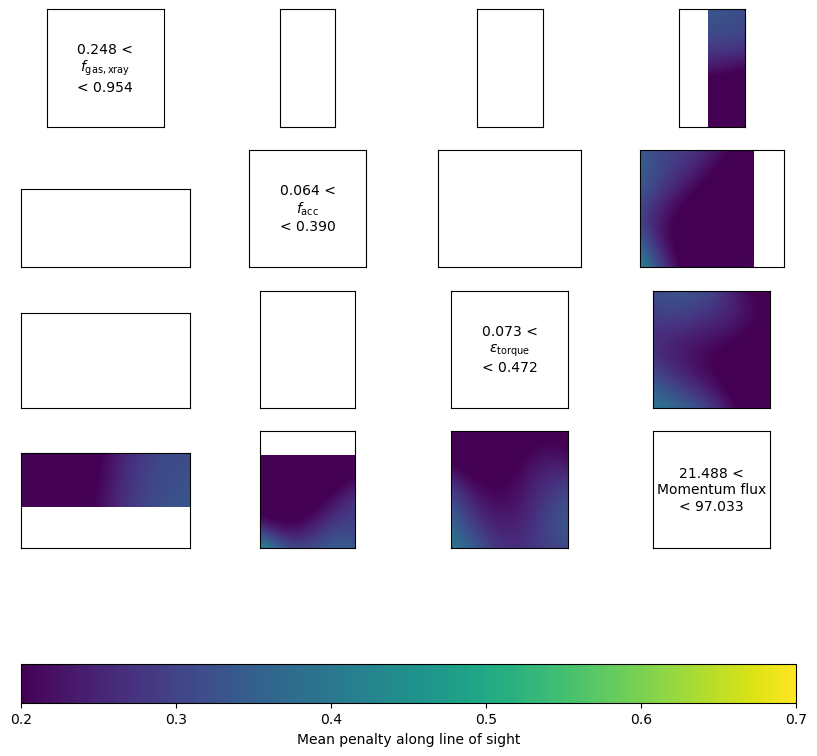

In [63]:
fig, ax = visualise_penalties_mean(gsmf_emulator.model_specification, gsmf_emulator.model_parameters, all_penalties,
                                   remove_ticks=True,
                                   figsize=(10,10),
#                                   use_parameters=["SIMBAAGN:xray_f_gas_limit"],
                                   use_colorbar=True)

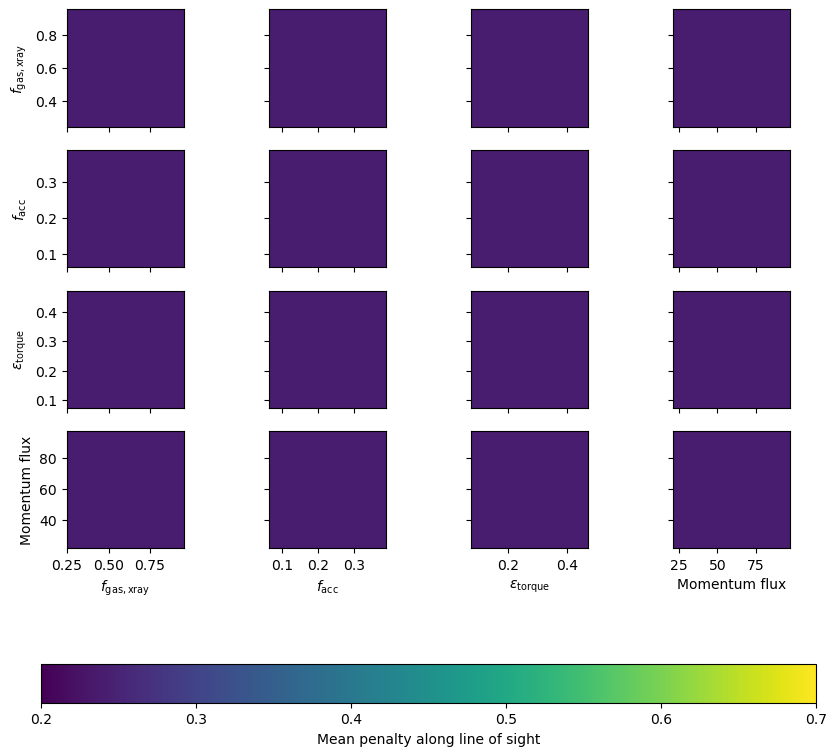

In [72]:
# Statistic options are: mean, std, median, count, sum, min, max, OR user defined function
fig, ax = visualise_penalties_generic_statistic(gsmf_emulator.model_specification, gsmf_emulator.model_parameters, all_penalties,
                                                statistic='mean',
                                               remove_ticks=False,
                                               figsize=(10,10),
#                                              use_parameters=["SIMBAAGN:xray_f_gas_limit"],
                                               use_colorbar=True)

## Fit emulator model to observational data

In [79]:
#popt, pcov = curve_fit(gsmf_emulator.predict_values, observation.x, observation.y)